# 03 - Unsupervised Action Segmentation

In this exercise, we are going to use features from a pretrained Vision Transformer model to perform action segmentation without labels.  The features we extract will be used to perform k-means clustering.  In theory, the clusters should represent distinct actions happening in the video.  Ideally, frames that are close to one another in time will have the same cluster.

In [1]:
import mediapy as media
from PIL import Image
from transformers import AutoImageProcessor, AutoModel
import tqdm
import torch

import matplotlib.pyplot as plt
import torch_spatial_kmeans as tsk
import numpy as np
import os

/project/nanocourse/PracArchDL23/shared/Day2Afternoon/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Feature Extraction

To extract the frame-level features, we are going to use a pretrained Vision Transformer.  Specifically, we will use the Dino v2 model released by Meta AI < [Paper page](https://dinov2.metademolab.com/) >.  This instance of the Vision Transformer was pretrained without supervision and relies soley on self-supervision techniques like self-distillation (iBOT) and in experiments is seen to work very well as a feature encoder for k-NN classifiers.

Furthermore, we will make use of the Huggingface library for its ease of use in working with pretrained models.  You can find more about the available sizes of DinoV2 models available on Huggingface Hub here: [Huggingface: DinoV2 Collection](https://huggingface.co/collections/facebook/dinov2-6526c98554b3d2576e071ce3)

In [150]:
# API reference here: https://huggingface.co/docs/transformers/v4.34.1/model_doc/dinov2

# This function will take an image as array of RGB and convert it to a sequence of image tokens
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')

# This function encapsulates DinoV2 model as a pretrained encoder
model = AutoModel.from_pretrained('facebook/dinov2-base')

# Make use of our GPU by move the model weights to the GPU
model.to(device)

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path1): Id

## Sample Data

Let's take a look at the video that we will be segmenting temporally using the [mediapy library](https://github.com/google/mediapy)

In [2]:
EXAMPLE_FILE = os.getenv('EXAMPLE_FILE')

video2 = media.read_video(EXAMPLE_FILE)

In [3]:
media.show_video(video2[3000:3500])

In this video, we see:
* A title screen
* A doctor enter the room
* A doctor begins speaking with the patient, asking questions
* A doctor examines a patient's chest and listens to their lungs
* Examines their ankles
* Examines their legs and feet
* A doctor closes by summarizing their assessment and plan for the patient

## Feature Extraction

In this section, we will use our DinoV2 model to extract frame level features for a sampling of frames.  At the end we will stack the list of frame level outputs into a \[N, D\] matrix where `N` is the number of frames and `D` is the embedding dimension of the DinoV2 encoder.

In [153]:
# Initialize our list for accumulating our embeddings
embeds = []

# We want to grab every 10th frame; video is originally 30fps so we will grab 3 embeddings per second
sampling = 10

with media.VideoReader('test.mp4') as vid:
    # For each frame...
    for i, frame in enumerate(tqdm.tqdm(vid)):
        # Skip unless its every 10th frame
        if i % sampling > 0:
            continue
            
        # Convert frame to PIL format
        image = Image.fromarray(frame)
        
        # Use processor to extract DinoV2 patches from the image
        inputs = processor(images=image, return_tensors="pt").to(device)
        
        # Generate the ouputs
        outputs = model(**inputs)
        
        # Only keep the pooled output - by default this is the [CLS] token
        embeds.append(outputs.pooler_output.detach().cpu())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
20113it [01:22, 244.51it/s]


In [154]:
# Stack up the embeddings into a feature matrix
embeds = torch.concat(embeds, axis=0)

In [155]:
embeds.shape

torch.Size([2012, 768])

## Frame Clustering

Using these frame level features, we will now use k-means clustering to automatically discovering groups of similar frames.  Rather than using traditional k-means clustering we will want to take advantage of the bias that frames that are close to each other temporally most likely participate in the same action.  We will use this [spatial k-means clustering library](https://github.com/mike-holcomb/torch-spatial-kmeans) that leverages a kernel that calculates the distance as the weighted sum of the L2 distance  between embeddings as well as the L2 distance between their coordinates.  In this application, we will use the time coordinate in our to encourage adjacent frames to land in the same cluster.

In [156]:
help(tsk.spatial_kmeans)

Help on function spatial_kmeans in module torch_spatial_kmeans:

spatial_kmeans(data: torch.Tensor, k: int, spatial_weight: float = 1.0, num_spatial_dims: int = 2, max_iters: int = 100) -> (<class 'torch.Tensor'>, <class 'torch.Tensor'>)
    Perform spatial K-means clustering.
    
    Args:
        data (torch.Tensor): The data to cluster. Shape (N, D).
        k (int): The number of clusters.
        spatial_weight (float): The weight to apply to the spatial distance.
        num_spatial_dims (int): The number of spatial dimensions.
        max_iters (int): The maximum number of iterations.
    
    Returns:
        torch.Tensor: The centroids. Shape (K, D).
        torch.Tensor: The cluster assignments for each data point. Shape (N,).
    
    Examples:
    
            >>> data = torch.tensor([[1, 2, 3], [4, 5, 6]])
            >>> centroids, cluster_assignments = spatial_kmeans(data, k=2, spatial_weight=0.5, num_spatial_dims=2)
            >>> centroids
            tensor([[1, 2, 

In [16]:
# Let's add a column to capture the temporal coordinate

data = torch.cat([embeds, torch.linspace(-1,1,len(embeds)).unsqueeze(1)], axis=1)

In [17]:
# Let's z-normalize the data since k-means prefers hyperspherical data

data = (data - data.mean(axis=1, keepdim=True))/data.std(axis=1, keepdim=True)

In [157]:
# Out data for processing should now be 768 feature dimensions + 1 coordinate dimension for time
data.shape

torch.Size([2012, 769])

In [172]:
# Let's set our hyperparameters here that we can tune later
n_clusters = 10
spatial_weight = 200

# Run our k_means
centroids, cluster_assignments = tsk.spatial_kmeans(data, k=n_clusters, spatial_weight=spatial_weight, num_spatial_dims=1)

## Visualization

Now that we have gotten our clusters, let's see on our timeline how these clusters evolve:

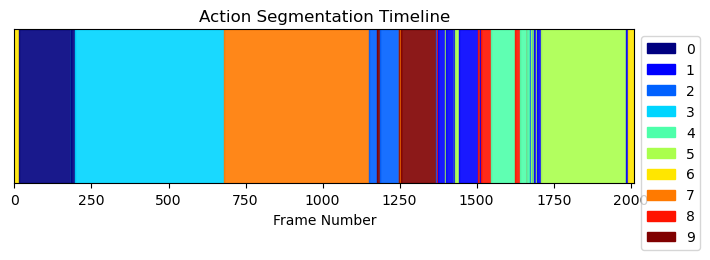

In [173]:
import matplotlib.pyplot as plt

action_ids = cluster_assignments.numpy()
n_frames = len(action_ids)
frame_numbers = np.arange(n_frames)

# Define the unique actions and assign a color to each
unique_actions = np.unique(action_ids)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_actions)))  # Using the jet colormap
action_colors = dict(zip(unique_actions, colors))

# Plotting the segmentation timeline
plt.figure(figsize=(8, 2))  # Adjust the size as needed
current_action = action_ids[0]
start_frame = 0

for i in range(1, n_frames):
    if action_ids[i] != current_action:
        plt.axvspan(start_frame, i, color=action_colors[current_action], alpha=0.9)
        start_frame = i
        current_action = action_ids[i]

# For the last segment
plt.axvspan(start_frame, n_frames, color=action_colors[current_action], alpha=0.9)

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=action_colors[id_]) for id_ in unique_actions]
plt.legend(handles, unique_actions, loc='upper left', bbox_to_anchor=(1, 1))

# Add labels and title
plt.xlabel('Frame Number')
plt.yticks([])
plt.title('Action Segmentation Timeline')
plt.xlim(0,n_frames)

# Show the plot
plt.show()

### Representative Frames

To help us understand what is in each of these clusters, let's find in the data the frames that are closest to each of the centroids of our clusters as representative frames for each cluster.

In [174]:
help(tsk.custom_kernel)

Help on function custom_kernel in module torch_spatial_kmeans:

custom_kernel(X, Y, spatial_weight, num_spatial_dims)
    Compute the combined distance between two sets of points.
    
    Args:
        X (torch.Tensor): The first set of points. Shape (N, D).
        Y (torch.Tensor): The second set of points. Shape (M, D).
        spatial_weight (float): The weight to apply to the spatial distance.
        num_spatial_dims (int): The number of spatial dimensions.
        
    Returns:
        torch.Tensor: The combined distance between the two sets of points.
    
    Examples:
    
        >>> X = torch.tensor([[1, 2, 3], [4, 5, 6]])
        >>> Y = torch.tensor([[7, 8, 9], [10, 11, 12]])
        >>> custom_kernel(X, Y, spatial_weight=0.5, num_spatial_dims=2)
        tensor([[ 54.0000,  99.0000],
                [ 99.0000, 144.0000]])



In [175]:
# Calculate the distance for every frame to every centroid
dists =tsk.custom_kernel(data, centroids, spatial_weight=spatial_weight, num_spatial_dims=1)

# Representative frames are the "closest" frames to the centroids
representative_frames = torch.argmin(dists,axis=0)

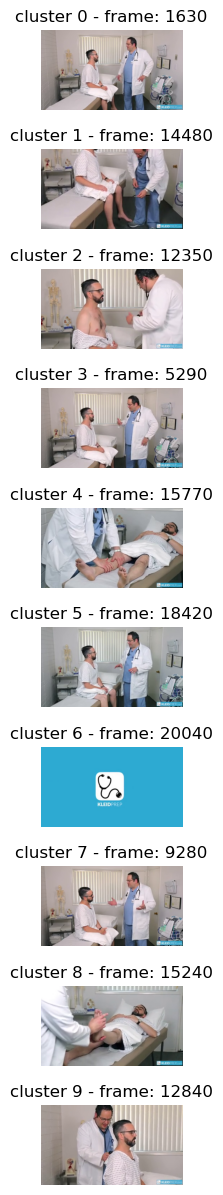

In [176]:
# Let's take a look at what is in each of these frames

fig, axs = plt.subplots(n_clusters, 1, gridspec_kw={"hspace": 0.5}, figsize=(3,15))

for i, idx in enumerate(representative_frames):
    axs[i].imshow(video2[idx*sampling])
    axs[i].axis("off")
    axs[i].set_title(f"cluster {i} - frame: {idx.item()*sampling}")

## BONUS: Multi-Modal Vision Transformers

Vision Transformers also play a role in multi-modal transformers that is deep learning architectures that combine more than one modality such as vision, textual, or audio features.  Here we use a multi-modal ViT called Blip from salesforce to automatically caption our representative frames.  The details of this architecture are beyond the scope of this course, but more details about this particular model can be found here: [BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation](https://blog.salesforceairesearch.com/blip-bootstrapping-language-image-pretraining/)

In [177]:
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

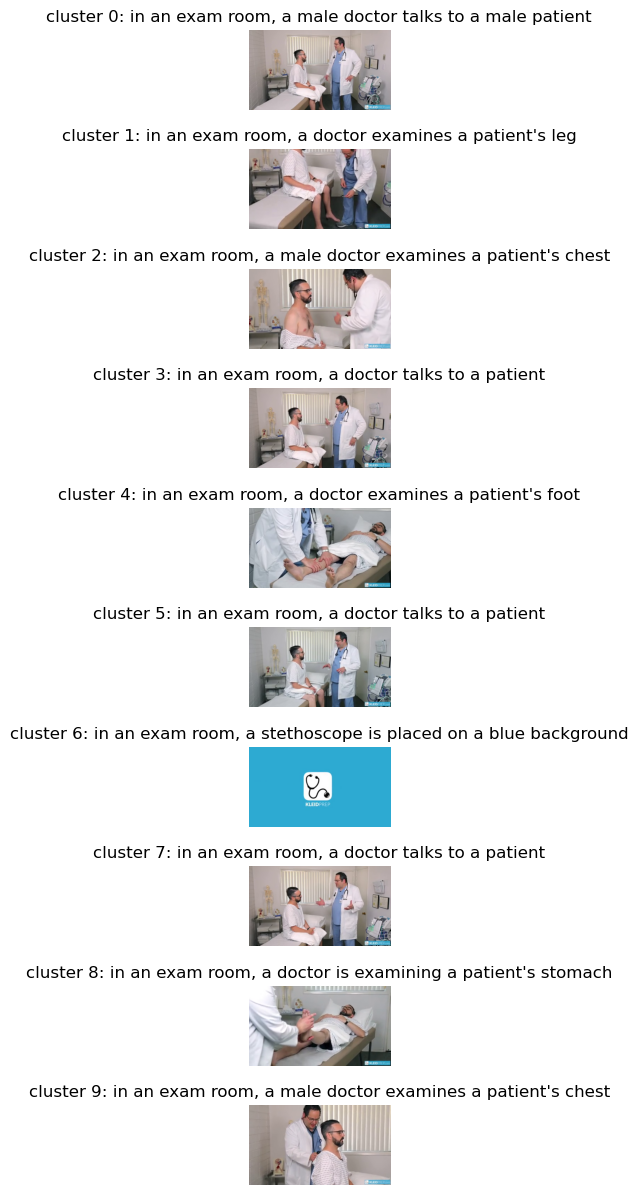

In [178]:
fig, axs = plt.subplots(n_clusters, 1, gridspec_kw={"hspace": 0.5}, figsize=(3,15))

# To help make the captions more grounded in our video, we can provide some conditioning text for the captions
text = "In an exam room,"

for i, idx in enumerate(torch.argmin(dists,axis=0)):
    # Grab the image data for the representative frame
    raw_image = video2[idx*sampling]
    
    # Convert the image and conditioning text to input tokens for the blip model
    inputs = blip_processor(raw_image, text, return_tensors="pt")
    
    # Run inference to grab the joint representation of the conditioning text and representative frame
    out = blip_model.generate(**inputs)
    
    # Decode the most likely tokens based on this encoding
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    
    axs[i].imshow(raw_image)
    axs[i].axis("off")
    axs[i].set_title(f"cluster {i}: {caption}")